# HR Churn Analysis

# Import Libraries

In [0]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

plt.rcParams['figure.facecolor'] = 'w' # For Colab in dark mode
sns.set()
#current_palette = sns.color_palette("cubehelix")
#current_palette = sns.color_palette("Paired")
#sns.set_palette(current_palette)

# Specify the custom font to use

plt.rcParams["axes.labelweight"] = "bold"

# Save path for whatever needs to be output
save_path = ''

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import classification_report

from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# EDA

In [0]:
path = ''

In [0]:
df = pd.read_csv(path, index_col=[0])

In [0]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [0]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


 Check for nulls

In [0]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

**OBSERVATIONS**: No null entries.

Look at correlation matrix for continuous variables.

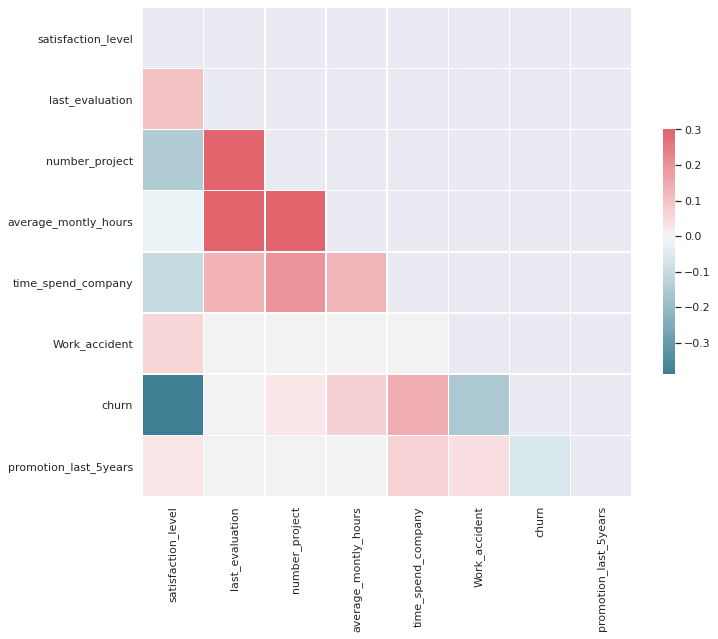

In [0]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**OBSERVATIONS**: 
* The lower the satisfaction level, the more likely the employee will churn.
* Occurence of work accident could also contribute to employees churning.
* Obviously, more projects lead to longer work hours.


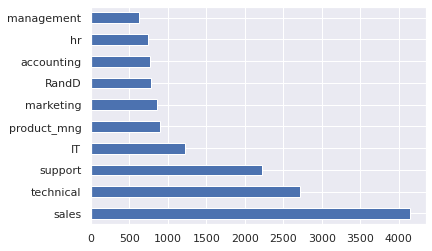

In [0]:
df['sales'].value_counts().plot(kind='barh')

**OBSERVATIONS**: Most employees in this company are from sales.

Look at how churning is distributed among different departments./

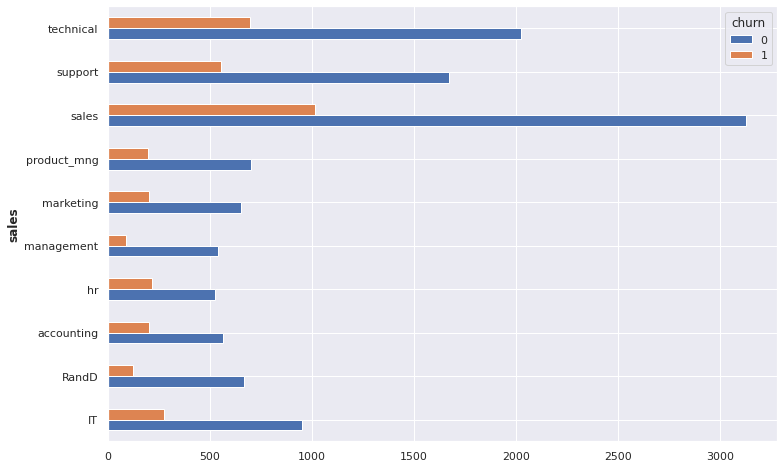

In [0]:
df.groupby(['sales'])['churn'].value_counts().unstack().plot(kind='barh', figsize=(12,8))

**OBSERVATIONS**: Most people that have churned are from techinical, support, and sales.

Text(0.5, 0, 'Satisfaction Level')

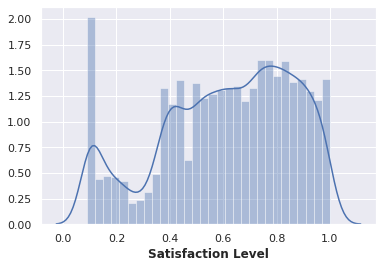

In [0]:
# Look at the distribution of satisfaction levels
sns.distplot(df['satisfaction_level'])
plt.xlabel('Satisfaction Level')

**OBSERVATIONS**: A wide range of satisfaction from employees.

([<matplotlib.axis.XTick at 0x7f02f3f122e8>,
 [Text(0, 0, 'No Churn'), Text(0, 0, 'Churn')])

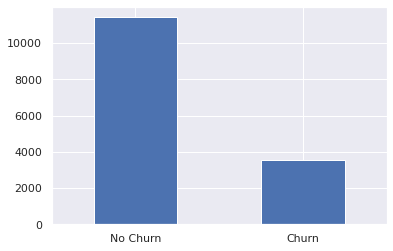

In [0]:
# Look at the distribution of the target class: Churn
df['churn'].value_counts().plot(kind='bar')
plt.xticks((0,1),('No Churn', 'Churn'), rotation=0)

**OBSERVATIONS**: We can see an imbalance of target classes in this data set.

# Preprocessing

We note that the categorical variables of `sales` and `salary` need to be encoded.

Dummy the `sales` variable.

In [0]:
df = pd.get_dummies(df, prefix='dept', columns=['sales'])

In [0]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [0]:
salary_dict = {'low':-1, 'medium':0, 'high':1}

In [0]:
df['salary'] = df['salary'].map(salary_dict)

In [0]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,salary,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
id,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,-1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,-1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,-1,0,0,0,0,0,0,0,1,0,0


Separate the features and the target class.

In [0]:
df.columns.tolist()

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'churn',
 'promotion_last_5years',
 'salary',
 'dept_IT',
 'dept_RandD',
 'dept_accounting',
 'dept_hr',
 'dept_management',
 'dept_marketing',
 'dept_product_mng',
 'dept_sales',
 'dept_support',
 'dept_technical']

In [0]:
input_var = [
     'satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'salary',
 'dept_IT',
 'dept_RandD',
 'dept_accounting',
 'dept_hr',
 'dept_management',
 'dept_marketing',
 'dept_product_mng',
 'dept_sales',
 'dept_support',
 'dept_technical'
]

output_var = ['churn'] 

In [0]:
X = df[input_var]
y = df[output_var]

Ensemble models are used for this analysis so there is no need to standardize the values.

Train-test split data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)